# Hyper parameters tuning
### Predicting Pneumonia from X-Ray image

Jimena Salinas Valdespino, Santiago Segovia Baquero, Stephania Tello Zamudio, Ivanna Rodríguez Lobo

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer

from torch.utils import data
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.io import read_image
from torchsummary import summary

from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

## Creating a Pytorch Dataset


We begin by implementing a class that handles the data:

In [2]:
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, img_dir_path, resize=False, transform=None):
        """
        Inputs:
            - csv_file (str): file path to the csv file
            - img_dir_path: directory path to the images
            - transform: Compose (a PyTorch Class) that strings together several
              transform functions (e.g. data augmentation steps)
        """
        self.img_labels = pd.read_csv(csv_file, skiprows=1, header=None)
        self.img_dir = img_dir_path
        self.transform = transform
        self.resize = resize
        self.dimensions = self.get_dimensions()

    def __len__(self):
        """
        Returns: (int) length of your dataset
        """
        return len(self.img_labels)

    def __getitem__(self, idx):
        """
        Loads and returns your sample (the image and the label) at the
        specified index

        Parameter: idx (int): index of interest

        Returns: image, label
        """
        img_path =  os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        
        # read the image
        image = read_image(img_path)

        # get the label
        label = self.img_labels.iloc[idx, 1]

        # apply transformations to image
        if self.transform:
            image = self.transform(image)
            
        # resize
        if self.resize:
            image = self.resize_image(image)
        
        if image.shape[0] > 1: # if it has more than one channels
            g = T.Grayscale(1)
            image = g(image)

        return image, label
    
    def get_dimensions(self):
        """
        This method creates a dictionary with the unique combinations of heightxwidth
        for each image in the dataset.

        returns a dictionary with dimensions as keys and the number of images
            with that dimension as values
        """
        dimensions = {}
        for index in range(len(self.img_labels)):
            image = self[index][0]
            if self.resize:
                image = self.resize_image(image)
            _, height, width = image.shape
            dimensions[(height,width)] = dimensions.get((height,width),0) + 1

        return dimensions
    
    def resize_image(self,image):
        """
        If the resize parameter==True, then all the images are
        converted to a 150x150 size.

        returns the resized image
        """
        transform = T.Resize((150,150))
        
        return transform(image)

Next, we apply the following transformation to the images to reduce the chance of overfitting our model to the observed data:

1. Rotate the image by 30 degrees
2. Zoom into the image by 20%
3. Flip the image horizontally
4. Increase the image's sharpness
5. Change the color depth of the image

In [3]:
train_transform = T.Compose([
    T.RandomRotation(30),
    T.RandomResizedCrop(size=(150, 150), scale=(0.8, 1.2)),
    T.RandomHorizontalFlip(),
    T.RandomAdjustSharpness(sharpness_factor=2),
    T.RandomPosterize(bits=4),
])

Then, we create a dataset for `train`, `validation`, and `testing` applying the aforementioned transformations (this step takes ~4 minutes):

In [4]:
train_data = CustomImageDataset(csv_file = '../data/data_train.csv',
                                img_dir_path = '../data',
                                resize=True,
                                transform=train_transform)

In [5]:
val_data = CustomImageDataset(csv_file = '../data/data_val.csv',
                              img_dir_path = '../data',
                              resize=True,
                              transform=train_transform)

In [6]:
test_data = CustomImageDataset(csv_file = '../data/data_test.csv',
                               img_dir_path = '../data',
                               resize=True,
                               transform=train_transform)

## Creating the DataLoader

The purpose of doing this is to load our data in batches to fit and test our model (this step takes ~4 minutes):

In [7]:
train_dataloader = DataLoader(train_data, 
                              batch_size=4, 
                              shuffle=True)

val_dataloader = DataLoader(val_data, 
                            batch_size=4, 
                            shuffle=True)

test_dataloader = DataLoader(test_data, 
                             batch_size=4, 
                             shuffle=True)

# Defining the Model

In [63]:
class CustomNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
      
      # inspire by Turing award winning LeCun, Bengio and Hinton's paper from 1998
      # https://ieeexplore.ieee.org/document/726791 (cited more than 25,000 times!!!!!!!!!)
      # code from https://blog.paperspace.com/writing-lenet5-from-scratch-in-python/ 
      
        # self.LeNet = nn.Sequential(     
        # convolutional layers
        
        self.Layer1 = nn.Sequential(                                            # FIRST LAYER: (INPUT LAYER)
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),    # CONVOLUTION 
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))             # POOLING
        self.Layer2 = nn.Sequential(                                            # SECOND LAYER: HIDDEN LAYER 1
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),   # CONVOLUTION 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))             # POOLING
          # fully connected layers
        self.F = nn.Flatten()
        
        self.LeNet = nn.Sequential(
            nn.Sequential(                                            
                nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),    
                nn.BatchNorm2d(6),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 2, stride = 2)),
            nn.Sequential(                                            
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0), 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)),
            nn.Flatten()
        )
      

      # Calculate the input size for the linear layer
        output_shape = self._get_conv_output_shape()
        input_size = output_shape[0] * output_shape[1]

      #self.classifier = nn.Sequential(
        self.lin1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU()       
        self.lin2 = nn.Linear(64, 64)
        self.relu2 = nn.ReLU()              
        self.output = nn.Linear(64,2) 
                                                 
    
    def _get_conv_output_shape(self):
      # Create a dummy tensor and pass it through the convolutional layers
        x = torch.zeros((1, 1, 150, 150))
        conv_output = self.LeNet(x)
        return conv_output.shape

    def forward(self, x):
        out = self.Layer1(x)
        out = self.Layer2(out)
        out = self.F(out)
        out = self.lin1(out)
        out = self.relu1(out)
        out = self.lin2(out)
        out = self.relu2(out)
        out = self.output(out)
           
        return out

In [64]:
model = CustomNeuralNetwork()

# Model's performance

To assess the prediction capacity of our model we compare the model's loss an classification power. The first one is defined as the accuracy of the model in terms of the predicted probabilities, while the second refers to how good the model classifies the actual labels (*e.g.*, normal lungs or lungs with pneumonia).

The loss functions that we will use are:

1. Binary cross-entropy
2. Cross-entropy

On the other hand, the accuracy measures we'll use are:

1. Accuracy
2. F1

To assess the prediction capacity of our model we compare the model's loss an classification power. The first one is defined as the accuracy of the model in terms of the predicted probabilities, while the second refers to how good the model classifies the actual labels (*e.g.*, normal lungs or lungs with pneumonia).

Given that we are interested in classifying only two classes, the loss function that we'll use is the **binary cross-entropy**, which is defined as:

$$Loss = - \frac{1}{N} \sum_{i = 1}^{N} y_i \cdot log(\hat y_i) + (1 - y_i)\cdot log(1 - \hat y_i)$$

where $y_i$ is the label for the $i$-th observation, and $\hat y_i$ is the prediction. Intuitively the loss penalizes incorrect predictions more severely, with the logarithmic term amplifying the error when the predicted probability deviates from the true label. The overall loss is computed by averaging this binary cross-entropy loss over the entire training set.

On the other hand, the accuracy measures we'll use are:

1. **Accuracy**: provides an estimate of how well the model predicts the correct class labels

2. **F1**: combines the precision and recall metrics into a single value, providing a balanced assessment of the model's performance. Is particularly important for our case given that we have an imbalance dataset that contains more pneumonia images vs. normal images.

Both accuracy measures are going to be calculated for the train, validation and test dataset to evaluate the model's performance and potential overfitting.

In [65]:
#Creates a batch to analyze the shapes and # of parameter of the model:
batch = next(iter(train_dataloader))
x, labels = batch
x.shape
summary(model, (1, x.shape[2],x.shape[3]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 146, 146]             156
       BatchNorm2d-2          [-1, 6, 146, 146]              12
              ReLU-3          [-1, 6, 146, 146]               0
         MaxPool2d-4            [-1, 6, 73, 73]               0
            Conv2d-5           [-1, 16, 69, 69]           2,416
       BatchNorm2d-6           [-1, 16, 69, 69]              32
              ReLU-7           [-1, 16, 69, 69]               0
         MaxPool2d-8           [-1, 16, 34, 34]               0
           Flatten-9                [-1, 18496]               0
           Linear-10                   [-1, 64]       1,183,808
             ReLU-11                   [-1, 64]               0
           Linear-12                   [-1, 64]           4,160
             ReLU-13                   [-1, 64]               0
           Linear-14                   

In [75]:
# Define a loss function and optimizer:
criterion = nn.CrossEntropyLoss()
# criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train, Validate and Test the Model

In [76]:
EPOCHS = 6

train_losses = []
train_accuracies = []
train_f1 = []
val_losses = []
val_accuracies = []
val_f1 = []
test_accuracies = []
test_f1 = []

for e in range(EPOCHS):  # loop over the dataset multiple times
    # TRAIN
    # Make sure gradient tracking is on, and do a pass over the data
    model.train()
    running_loss_train = 0.0
    accuracies_train = []
    f1_scores_train = []
    print('Analyzing epoch:', e + 1, "for train dataset")
    for i, data in enumerate(train_dataloader):
        # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.float()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # keep track of the loss
            running_loss_train += loss.item()
            
            # Calculate accuracy metrics
            predicted = predicted.detach().numpy()
            labels = labels.detach().numpy()

            accuracy = metrics.accuracy_score(labels, predicted)
            accuracies_train.append(accuracy)

            f1score = metrics.f1_score(labels, predicted)
            f1_scores_train.append(f1score)

    #Average training loss  
    avg_train_loss = running_loss_train / (i + 1)     # i + 1 gives us the total number of batches in train dataloader
    train_losses.append(avg_train_loss)
    
    #Average train accuracy
    avg_train_acc = sum(accuracies_train)/len(accuracies_train)
    train_accuracies.append(avg_train_acc)
    
    ##Average train F1
    avg_train_f1 = sum(f1_scores_train)/len(f1_scores_train)
    train_f1.append(avg_train_f1)

    print('   Avg. train accuracy:',avg_train_acc)
    print('   Avg. train f1:',avg_train_f1)

    #VALIDATE
    # in the validation part, we don't want to keep track of the gradients 
    model.eval()
    running_loss_val = 0.0
    accuracies_val = []
    f1_scores_val = []
    print('Analyzing epoch:', e + 1, "for validation dataset")
    for i, data in enumerate(val_dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        inputs = inputs.float()

        # val prediction
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        loss = criterion(outputs, labels)
        # keep track of the loss
        running_loss_val += loss.item()

        # Calculate accuracy metrics
        predicted = predicted.detach().numpy()
        labels = labels.detach().numpy()

        accuracy = metrics.accuracy_score(labels, predicted)
        accuracies_val.append(accuracy)

        f1score = metrics.f1_score(labels, predicted)
        f1_scores_val.append(f1score)

    # Average validation loss
    avg_val_loss = running_loss_val / (i + 1)     # i + 1 gives us the total number of batches in train dataloader
    val_losses.append(avg_val_loss)

    # Average validation accuracy
    avg_val_acc = sum(accuracies_val)/len(accuracies_val)
    val_accuracies.append(avg_val_acc)

    #Average validation loss
    avg_val_f1 = sum(f1_scores_val)/len(f1_scores_val)
    val_f1.append(avg_val_f1)

    print('   Avg. val accuracy:',avg_val_acc)
    print('   Avg. val f1:',avg_val_f1)

    #TEST
    model.eval()
    accuracies_test = []
    f1_scores_test = []
    print('Analyzing epoch:', e + 1, "for test dataset")
    for i, data in enumerate(test_dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.float()

        # test prediction
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Calculate accuracy metrics
        predicted = predicted.detach().numpy()
        labels = labels.detach().numpy()

        accuracy = metrics.accuracy_score(labels, predicted)
        accuracies_test.append(accuracy)

        f1score = metrics.f1_score(labels, predicted)
        f1_scores_test.append(f1score)

    # CALCULATE AVERAGE ACCURACY METRIC
    avg_test_acc = sum(accuracies_test)/len(accuracies_test)   
    test_accuracies.append(avg_test_acc)  
    #CALCULATE AVERAGE F1 SCORE
    avg_test_f1 = sum(f1_scores_test)/len(f1_scores_test)
    test_f1.append(avg_test_f1)

    print('   Avg. test accuracy:',avg_test_acc)
    print('   Avg. test f1:',avg_test_f1)
    print()

Analyzing epoch: 1 for train dataset
   Avg. train accuracy: 0.94670245398773
   Avg. train f1: 0.955010224948875
Analyzing epoch: 1 for validation dataset
   Avg. val accuracy: 0.625
   Avg. val f1: 0.4916666666666667
Analyzing epoch: 1 for test dataset
   Avg. test accuracy: 0.8285256410256411
   Avg. test f1: 0.8504578754578757

Analyzing epoch: 2 for train dataset
   Avg. train accuracy: 0.9532208588957055
   Avg. train f1: 0.956536663745252
Analyzing epoch: 2 for validation dataset
   Avg. val accuracy: 0.875
   Avg. val f1: 0.875
Analyzing epoch: 2 for test dataset
   Avg. test accuracy: 0.8237179487179487
   Avg. test f1: 0.8324175824175827

Analyzing epoch: 3 for train dataset
   Avg. train accuracy: 0.9543711656441718
   Avg. train f1: 0.9606960268770082
Analyzing epoch: 3 for validation dataset
   Avg. val accuracy: 0.6875
   Avg. val f1: 0.575
Analyzing epoch: 3 for test dataset
   Avg. test accuracy: 0.8076923076923077
   Avg. test f1: 0.8406288156288156

Analyzing epoch: 4

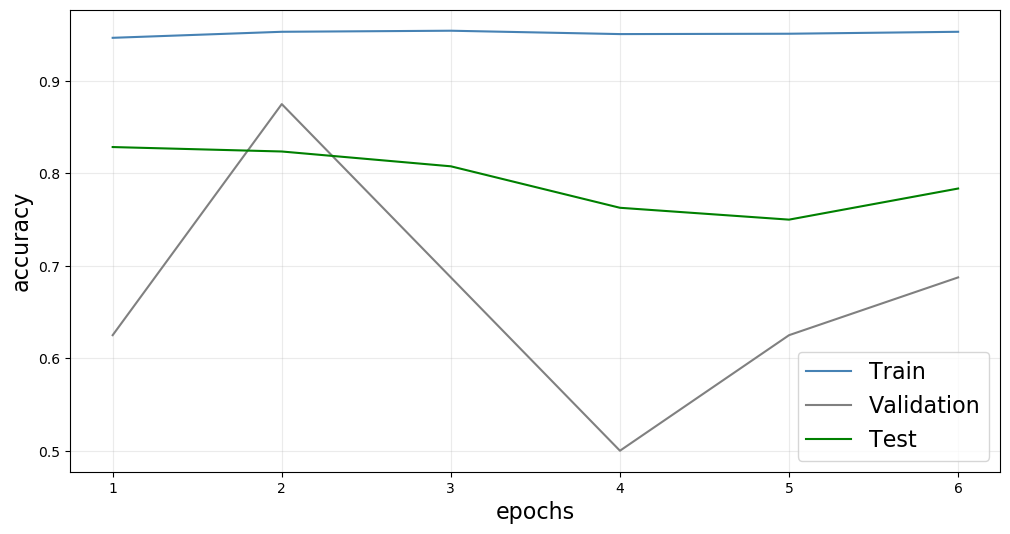

In [77]:
# Plotting the training, testing and validation accuracies
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
epochs_array = [i + 1 for i in range(0, EPOCHS, 1)]
ax.plot(epochs_array, train_accuracies, color="steelblue", label='Train')
ax.plot(epochs_array, val_accuracies, color="grey", label='Validation')
ax.plot(epochs_array, test_accuracies, color="green", label='Test')
ax.grid(alpha=0.25)
ax.legend(loc="lower right", fontsize=16)
ax.set_xlabel("epochs", fontsize=16)
ax.set_ylabel("accuracy", fontsize=16)
plt.show()

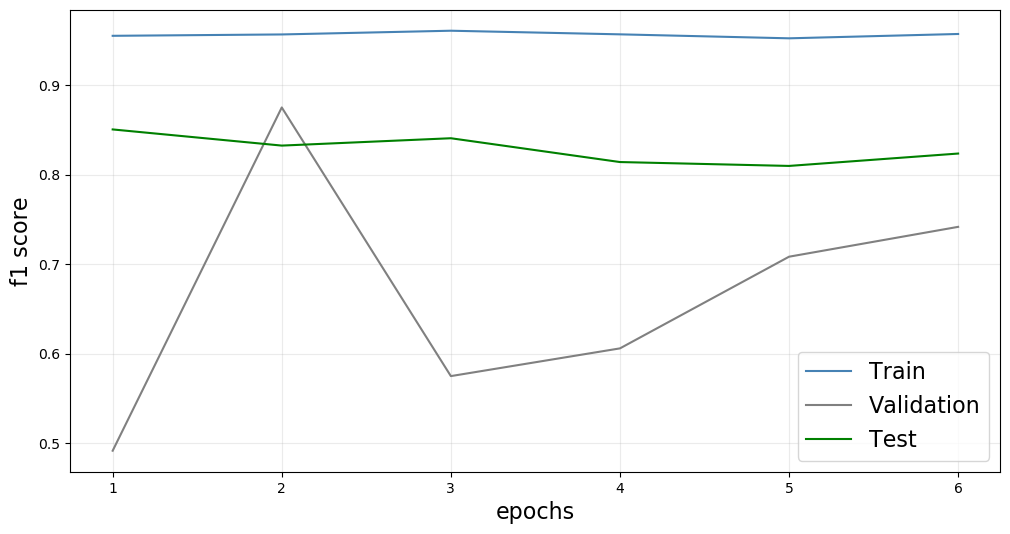

In [78]:
# Plotting the training, testing and validation F1 scores
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
epochs_array = [i + 1 for i in range(0, EPOCHS, 1)]
ax.plot(epochs_array, train_f1, color="steelblue", label='Train')
ax.plot(epochs_array, val_f1, color="grey", label='Validation')
ax.plot(epochs_array, test_f1, color="green", label='Test')
ax.grid(alpha=0.25)
ax.legend(loc="lower right", fontsize=16)
ax.set_xlabel("epochs", fontsize=16)
ax.set_ylabel("f1 score", fontsize=16)
plt.show()

From the graphs above, it seems like the trained convolutional neural network model performs well on the training data with a stable training accuracy of 0.95 after the first epoch. However, the testing accuracy remains around 0.8, which indicates that the model might be overfitting to the training data. This could be due to the unbalanced nature of the training dataset, with almost three times more images of pneumonia than normal. This suggests that the model might be biased towards predicting pneumonia more often.

The F1 score for training is around 0.95, which indicates that the model has a good balance between precision and recall for the training data. However, the F1 score for testing is 0.85, which suggests that the model's performance on the testing data is not as good as on the training data. This might be due to the unbalanced training dataset, which makes it difficult for the model to generalize well to new, unseen data.

In order to improve the model, we plan to run the model using a binary cross entropy loss function since it is specifically desgined for binary classification problems. We expect this could help the model's perfomance since this function penalizes more heavily for misclassifying instances from the minority class (i.e., normal in this case), which could help to address the imbalance in the training dataset. Additionally, we can try introducing a regularization term in order to prevent overfitting and improve the generalization ability of the model.

# Alternative Model

To compare the performance from our baseline model, we define a new one which is going to have the following characteristics:

1. Modify the number of filters in the first convolution from 6 to 10
2. Modify the number of filters in the first convolution from 10 to 16
3. Include an additional hidden layer
4. Do not perform max-pooling in the second hidden layer
5. Use Adam instead of SGD as an optimizer. This allows to include a regularization term to penalize complexities from our model.

This changes will also incrdecrease gradually the complexity of our model. In the previous one, the number of parameters estimated was 1,190,714, while in the new one the number will be 1,168,742.

In [79]:
class NewCustomNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
                
        self.Layer1 = nn.Sequential(                                            # FIRST LAYER: (INPUT LAYER)
            nn.Conv2d(1, 10, kernel_size=5, stride=1, padding=0),    # CONVOLUTION 
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))             # POOLING
        self.Layer2 = nn.Sequential(                                            # SECOND LAYER: HIDDEN LAYER 1
            nn.Conv2d(10, 16, kernel_size=5, stride=1, padding=0),   # CONVOLUTION 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))             # POOLING
        self.Layer3 = nn.Sequential(                                            # THIRD LAYER: HIDDEN LAYER 2
            nn.Conv2d(16, 20, kernel_size=5, stride=1, padding=0),   # CONVOLUTION 
            nn.BatchNorm2d(20),
            nn.ReLU())        
          # fully connected layers
        self.F = nn.Flatten()
        
        self.LeNet = nn.Sequential(
            nn.Sequential(                                            
                nn.Conv2d(1, 10, kernel_size=5, stride=1, padding=0),    
                nn.BatchNorm2d(10),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 2, stride = 2)),
            nn.Sequential(                                            
                nn.Conv2d(10, 16, kernel_size=5, stride=1, padding=0), 
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 2, stride = 2)),
            nn.Sequential(
                nn.Conv2d(16, 20, kernel_size=5, stride=1, padding=0),
                nn.BatchNorm2d(20),
                nn.ReLU()),
            nn.Flatten()
        )
      

      # Calculate the input size for the linear layer
        output_shape = self._get_conv_output_shape()
        input_size = output_shape[0] * output_shape[1]

      #self.classifier = nn.Sequential(
        self.lin1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU()       
        self.lin2 = nn.Linear(64, 64)
        self.relu2 = nn.ReLU()              
        self.output = nn.Linear(64,2)                                         
    
    def _get_conv_output_shape(self):
      # Create a dummy tensor and pass it through the convolutional layers
        x = torch.zeros((1, 1, 150, 150))
        conv_output = self.LeNet(x)
        return conv_output.shape

    def forward(self, x):
        out = self.Layer1(x)
        out = self.Layer2(out)
        out = self.Layer3(out)
        out = self.F(out)
        out = self.lin1(out)
        out = self.relu1(out)
        out = self.lin2(out)
        out = self.relu2(out)
        out = self.output(out)
           
        return out

In [80]:
model_2 = NewCustomNeuralNetwork()

In [70]:
#Creates a batch to analyze the shapes and # of parameter of the model:
batch = next(iter(train_dataloader))
x, labels = batch
x.shape
summary(model_2, (1, x.shape[2],x.shape[3]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 10, 146, 146]             260
       BatchNorm2d-2         [-1, 10, 146, 146]              20
              ReLU-3         [-1, 10, 146, 146]               0
         MaxPool2d-4           [-1, 10, 73, 73]               0
            Conv2d-5           [-1, 16, 69, 69]           4,016
       BatchNorm2d-6           [-1, 16, 69, 69]              32
              ReLU-7           [-1, 16, 69, 69]               0
         MaxPool2d-8           [-1, 16, 34, 34]               0
            Conv2d-9           [-1, 20, 30, 30]           8,020
      BatchNorm2d-10           [-1, 20, 30, 30]              40
             ReLU-11           [-1, 20, 30, 30]               0
          Flatten-12                [-1, 18000]               0
           Linear-13                   [-1, 64]       1,152,064
             ReLU-14                   

In [81]:
# Define a loss function and optimizer:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)

# Train, Validate and Test the Model

In [82]:
EPOCHS = 6

train_losses = []
train_accuracies = []
train_f1 = []
val_losses = []
val_accuracies = []
val_f1 = []
test_accuracies = []
test_f1 = []

for e in range(EPOCHS):  # loop over the dataset multiple times
    # TRAIN
    # Make sure gradient tracking is on, and do a pass over the data
    model.train()
    running_loss_train = 0.0
    accuracies_train = []
    f1_scores_train = []
    print('Analyzing epoch:', e + 1, "for train dataset")
    for i, data in enumerate(train_dataloader):
        # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.float()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # keep track of the loss
            running_loss_train += loss.item()
            
            # Calculate accuracy metrics
            predicted = predicted.detach().numpy()
            labels = labels.detach().numpy()

            accuracy = metrics.accuracy_score(labels, predicted)
            accuracies_train.append(accuracy)

            f1score = metrics.f1_score(labels, predicted)
            f1_scores_train.append(f1score)

    #Average training loss  
    avg_train_loss = running_loss_train / (i + 1)     # i + 1 gives us the total number of batches in train dataloader
    train_losses.append(avg_train_loss)
    
    #Average train accuracy
    avg_train_acc = sum(accuracies_train)/len(accuracies_train)
    train_accuracies.append(avg_train_acc)
    
    ##Average train F1
    avg_train_f1 = sum(f1_scores_train)/len(f1_scores_train)
    train_f1.append(avg_train_f1)

    print('   Avg. train accuracy:',avg_train_acc)
    print('   Avg. train f1:',avg_train_f1)

    #VALIDATE
    # in the validation part, we don't want to keep track of the gradients 
    model.eval()
    running_loss_val = 0.0
    accuracies_val = []
    f1_scores_val = []
    print('Analyzing epoch:', e + 1, "for validation dataset")
    for i, data in enumerate(val_dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        inputs = inputs.float()

        # val prediction
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        loss = criterion(outputs, labels)
        # keep track of the loss
        running_loss_val += loss.item()

        # Calculate accuracy metrics
        predicted = predicted.detach().numpy()
        labels = labels.detach().numpy()

        accuracy = metrics.accuracy_score(labels, predicted)
        accuracies_val.append(accuracy)

        f1score = metrics.f1_score(labels, predicted)
        f1_scores_val.append(f1score)

    # Average validation loss
    avg_val_loss = running_loss_val / (i + 1)     # i + 1 gives us the total number of batches in train dataloader
    val_losses.append(avg_val_loss)

    # Average validation accuracy
    avg_val_acc = sum(accuracies_val)/len(accuracies_val)
    val_accuracies.append(avg_val_acc)

    #Average validation loss
    avg_val_f1 = sum(f1_scores_val)/len(f1_scores_val)
    val_f1.append(avg_val_f1)

    print('   Avg. val accuracy:',avg_val_acc)
    print('   Avg. val f1:',avg_val_f1)

    #TEST
    model.eval()
    accuracies_test = []
    f1_scores_test = []
    print('Analyzing epoch:', e + 1, "for test dataset")
    for i, data in enumerate(test_dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.float()

        # test prediction
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Calculate accuracy metrics
        predicted = predicted.detach().numpy()
        labels = labels.detach().numpy()

        accuracy = metrics.accuracy_score(labels, predicted)
        accuracies_test.append(accuracy)

        f1score = metrics.f1_score(labels, predicted)
        f1_scores_test.append(f1score)

    # CALCULATE AVERAGE ACCURACY METRIC
    avg_test_acc = sum(accuracies_test)/len(accuracies_test)   
    test_accuracies.append(avg_test_acc)  
    #CALCULATE AVERAGE F1 SCORE
    avg_test_f1 = sum(f1_scores_test)/len(f1_scores_test)
    test_f1.append(avg_test_f1)

    print('   Avg. test accuracy:',avg_test_acc)
    print('   Avg. test f1:',avg_test_f1)
    print()

Analyzing epoch: 1 for train dataset
   Avg. train accuracy: 0.9457438650306749
   Avg. train f1: 0.9533924919661114
Analyzing epoch: 1 for validation dataset
   Avg. val accuracy: 0.625
   Avg. val f1: 0.7083333333333333
Analyzing epoch: 1 for test dataset
   Avg. test accuracy: 0.7387820512820513
   Avg. test f1: 0.804517704517705

Analyzing epoch: 2 for train dataset
   Avg. train accuracy: 0.9488113496932515
   Avg. train f1: 0.956061933976044
Analyzing epoch: 2 for validation dataset
   Avg. val accuracy: 0.6875
   Avg. val f1: 0.7476190476190476
Analyzing epoch: 2 for test dataset
   Avg. test accuracy: 0.7612179487179487
   Avg. test f1: 0.7929792429792433

Analyzing epoch: 3 for train dataset
   Avg. train accuracy: 0.9482361963190185
   Avg. train f1: 0.9554703476482617
Analyzing epoch: 3 for validation dataset
   Avg. val accuracy: 0.75
   Avg. val f1: 0.7416666666666667
Analyzing epoch: 3 for test dataset
   Avg. test accuracy: 0.8669871794871795
   Avg. test f1: 0.864010989

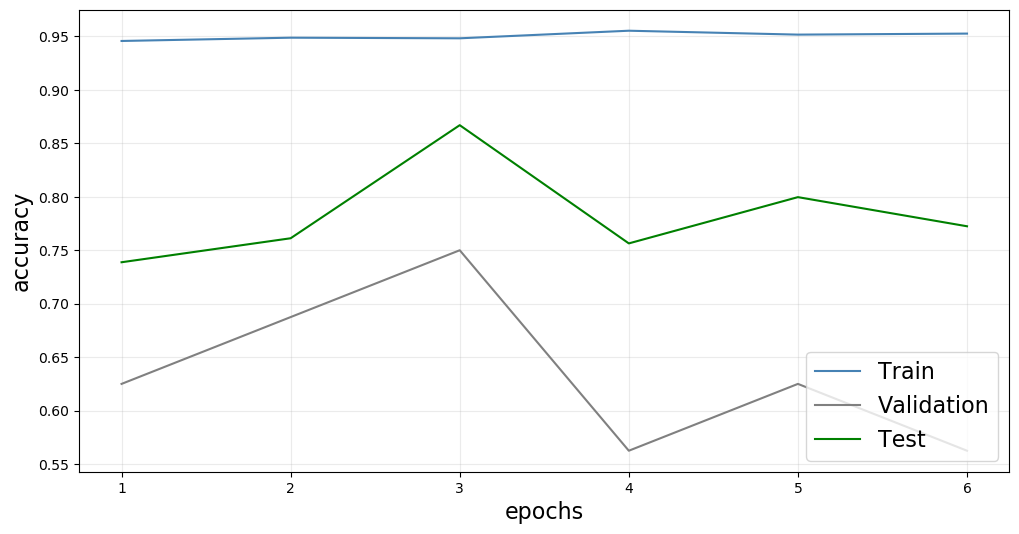

In [83]:
# Plotting the training, testing and validation accuracies
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
epochs_array = [i + 1 for i in range(0, EPOCHS, 1)]
ax.plot(epochs_array, train_accuracies, color="steelblue", label='Train')
ax.plot(epochs_array, val_accuracies, color="grey", label='Validation')
ax.plot(epochs_array, test_accuracies, color="green", label='Test')
ax.grid(alpha=0.25)
ax.legend(loc="lower right", fontsize=16)
ax.set_xlabel("epochs", fontsize=16)
ax.set_ylabel("accuracy", fontsize=16)
plt.show()

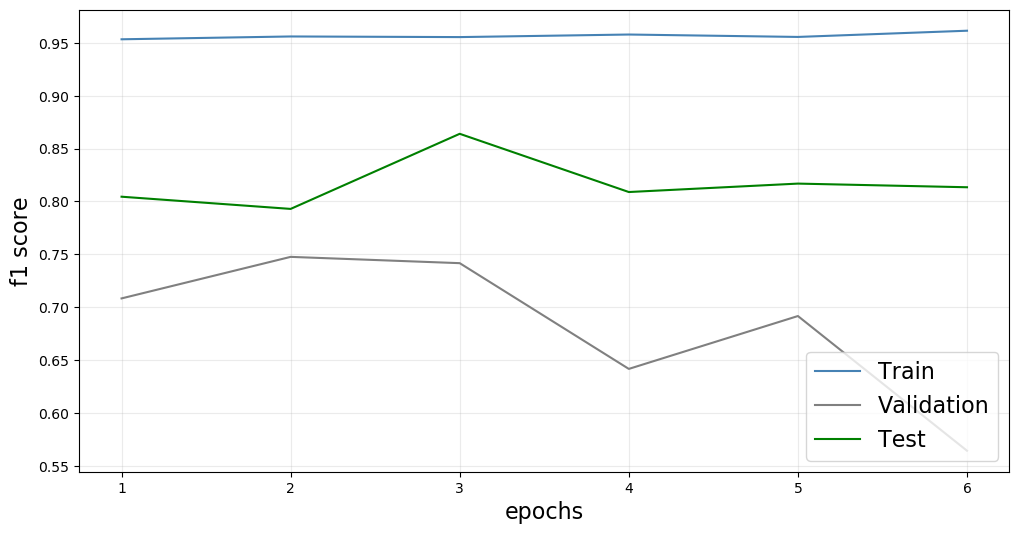

In [84]:
# Plotting the training, testing and validation F1 scores
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
epochs_array = [i + 1 for i in range(0, EPOCHS, 1)]
ax.plot(epochs_array, train_f1, color="steelblue", label='Train')
ax.plot(epochs_array, val_f1, color="grey", label='Validation')
ax.plot(epochs_array, test_f1, color="green", label='Test')
ax.grid(alpha=0.25)
ax.legend(loc="lower right", fontsize=16)
ax.set_xlabel("epochs", fontsize=16)
ax.set_ylabel("f1 score", fontsize=16)
plt.show()